In [1]:
!pip install avro-python3

  Using cached avro-1.9.2.tar.gz (49 kB)
    Running setup.py install for avro ... done


# Converting .tar.gz Files to AVRO

The files in the Google Open Image dataset are compressed into large .tar.gz archive files. Unfortunately, this file format does not fit into the Hadoop ecosystem well. I even tried to just extract and upload the individual files but I ran into a maximum number of files in a directory limit of HDFS (above 2 million something files).

This document converts the .tar.gz files into an AVRO file containing the file name and the image data.

## AVRO Schema

Read more about AVRO [AVRO Docs](https://avro.apache.org/docs/current/spec.html#schemas). 

In [1]:
record_schema = """
{
     "type": "record",
     "namespace": "google.open.image",
     "name": "image",
     "fields": [
       { "name": "id", "type": "string" },
       { "name": "subset", "type": {
               "type": "enum",
               "name": "subsets",
               "symbols": ["TEST", "TRAIN", "VALIDATION"]
           }
       },
       { "name": "format", "type": {
         "type": "enum",
               "name": "image_formats",
               "symbols": ["JPG", "PNG"]
       }
       },
       { "name": "data",
         "type": "bytes"}
     ]
}
"""

# Write a Dummy Document to Test AVRO Lib

In [ ]:
# note, for python 3, pip install avro-python3
#
import avro.schema
from avro.datafile import DataFileReader, DataFileWriter
from avro.io import DatumReader, DatumWriter
import os

In [2]:
schema = avro.schema.parse(record_schema)

writer = DataFileWriter(open("test.avro", "wb"), DatumWriter(), schema)

# Create some dummy records. os.urandom just creates some random bytes
writer.append({"id": "first",  "subset": "TEST",       "format": "JPG", "data": os.urandom(10)})
writer.append({"id": "second", "subset": "VALIDATION", "format": "PNG", "data": os.urandom(15)})
writer.append({"id": "third",  "subset": "TRAIN",      "format": "JPG", "data": os.urandom(3)})

writer.close()

if you dump the raw bytes of that file in the terminal, you'll see that the enum fields are replaced with integers, so we're not re-writing "TEST" or "JPG" for each record.

# Now convert entry from .tar.gz to AVRO

Read .tar.gz files from HDFS

In [3]:
import pyarrow as pa

In [4]:
hdfs = pa.hdfs.HadoopFileSystem('10.3.0.2', 8020)
hdfs.connect()

## Find data in HDFS

The data we're interested in is in /data/google_open_image/

In [5]:
# get list of files
image_dir_list = hdfs.ls('/data/google_open_image/images')
# filter list of anything not a .tar.gz file
image_tar_gz_files = [file for file in image_dir_list if ".tar.gz" in file]
image_tar_gz_files 

['/data/google_open_image/images/test.tar.gz',
 '/data/google_open_image/images/train_0.tar.gz',
 '/data/google_open_image/images/train_1.tar.gz',
 '/data/google_open_image/images/train_2.tar.gz',
 '/data/google_open_image/images/train_3.tar.gz',
 '/data/google_open_image/images/train_4.tar.gz',
 '/data/google_open_image/images/train_5.tar.gz',
 '/data/google_open_image/images/train_6.tar.gz',
 '/data/google_open_image/images/train_7.tar.gz',
 '/data/google_open_image/images/train_8.tar.gz',
 '/data/google_open_image/images/train_9.tar.gz',
 '/data/google_open_image/images/train_a.tar.gz',
 '/data/google_open_image/images/train_b.tar.gz',
 '/data/google_open_image/images/train_c.tar.gz',
 '/data/google_open_image/images/train_d.tar.gz',
 '/data/google_open_image/images/train_e.tar.gz',
 '/data/google_open_image/images/train_f.tar.gz',
 '/data/google_open_image/images/validation.tar.gz']

## Reading files from a tarfile



In [6]:
import tarfile

# grab a random image from the first tar archive.
tarball = image_tar_gz_files[0]

print(f"opening tarball in HDFS: {tarball}")
tf_handle = hdfs.open(tarball)

# pass hdfs handle to tarfile library
tar = tarfile.open(fileobj = tf_handle)
member = tar.next() # read first object / file from archive

file_counter = 0
while member is not None and file_counter < 814:
    # tar archives generally contain paths / directories, so be sure to only grab things that are actually files
    if not member.isfile():
        member = tar.next()
        continue
    f = tar.extractfile(member)
    content = f.read()
    f.close()
    member = tar.next()
    file_counter = file_counter + 1

tar.close() # be a good citizen and close files.


opening tarball in HDFS: /data/google_open_image/images/test.tar.gz


In [7]:
member.path

'test/69bf57a4a68caea8.jpg'

In [8]:
from PIL import Image
import io

jpg = Image.open(io.BytesIO(content))

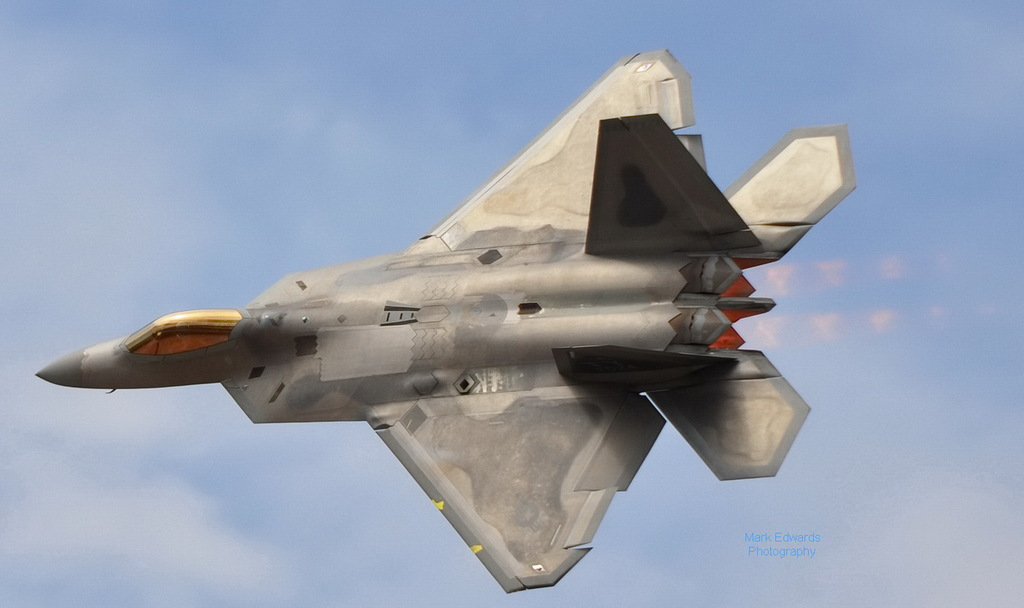

In [9]:
jpg

# Create an AVRO record with the real data

## Extract Subset (Test, Validation, Train) From Path

In [10]:
member.path

'test/69bf57a4a68caea8.jpg'

In [11]:
directory = os.path.dirname(member.path)
image_subset = directory.upper()
image_subset

'TEST'

## Extract Image ID from Filename

In [12]:
filename = os.path.basename(member.path)
filename

'69bf57a4a68caea8.jpg'

In [13]:
filename_parts = os.path.splitext(filename)
filename_parts

('69bf57a4a68caea8', '.jpg')

In [14]:
image_id = filename_parts[0]
image_id

'69bf57a4a68caea8'

## Get File Type from File name

In [15]:
image_format = filename_parts[1].replace(".", "").upper()
image_format

'JPG'

## Create Dict With AVRO Schema Naming

In [16]:
record = {"id": image_id,  "subset": image_subset, "format": image_format, "data": content}

## Write the record to a test file in HDFS

In [17]:
avro_outfile = hdfs.open(path = f'/user/{os.environ["USER"]}/test2.avro', 
          mode = 'wb')

writer = DataFileWriter(avro_outfile, DatumWriter(), schema)

writer.append(record)
writer.close()
